# Advanced Lane Finding Project

The tasks to accomplish in this project are as following:

 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 2. Apply a distortion correction to raw images.
 3. Use color transforms, gradients, etc., to create a thresholded binary image.
 4. Apply a perspective transform to rectify binary image ("birds-eye view").
 5. Detect lane pixels and fit to find the lane boundary.
 6. Determine the curvature of the lane and vehicle position with respect to center.
 7. Warp the detected lane boundaries back onto the original image.
 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import necessary packages
import os
import numpy as np
import glob # to read files from dir
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

os.getcwd()

'C:\\Jandal\\workspace_P\\UNDSC\\CarND-Advanced-Lane-Lines'

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
The solution can be found in <font color=blue>Stage0_Camera_Calibration.ipynb</font> notebook in this directory.

### 2 - 4 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_a.ipynb</font> notebook in this directory.

### 5 - 8 steps 
The solution can be found in <font color=blue>Stage1_Pipeline_b.ipynb</font> notebook in this directory.

### This notebook has end to end pipeline executed on test images and sample video

In [2]:
# Reading camera calibration variables from pickle object
path_dir = os.getcwd()+"\\pickled_data\\"
pickle_obj = pickle.load(open(path_dir+"camera_calibration.p", "rb" ))
mtx = pickle_obj["mtx"]
dist = pickle_obj["dist"]

#### All helper functions required for pipeline can be found in <font color=blue>pipeline_helper_functions.py</font>

In [3]:
# Getting helper functions
%run pipeline_helper_functions.py

### Defining Image Pipeline

In [15]:
# Defining pipeline function using helper functions
def pipeline(original_image):
    #1. Undistort, blur and find combined thresholded image
    undist_img = undistorted_img(original_image, mtx, dist)
    blur_img = cv2.GaussianBlur(undist_img, (9, 9), 0)
    combined_img = get_comb_binarized(blur_img)

    #2. Get warp perspective of undistorted image
    src = np.float32([[550, 470], [760, 470], [1125, 670], [200, 670]])
    #dst = np.float32([[10, 10], [1200, 10], [1200, 700], [10, 700]])
    offset = 10
    h,w = combined_img.shape
    dst = get_dst(offset=offset, w=w, h=h)
    warped_img = WarpPerspective(combined_img, src, dst) # get perspective transformation
    
    #3. Get sliding windows
    left_fit,right_fit,left_lane_inds,right_lane_inds,out_img = make_sliding_windows(warped_img)
    #slidingWindows = visualize_sliding_windows(warped_img,left_fit,right_fit,out_img)
    
    #4. Get smooth lane pixels, alternative to sliding windows method
    margin = 100 # hyper-param
    smoothLanes, left_fitx, right_fitx, ploty = get_smooth_lanes(warped_img, margin, left_fit, right_fit)
    smoothLanes = cv2.cvtColor(smoothLanes.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    #visualize_smooth_lanes(left_fitx, right_fitx, ploty)
    
    #5. Unwarp to original image
    unwarp_img = unwarp_image(smoothLanes, original_image, src, dst, left_fit, right_fit)
    
    #6. Print radius of curvature
    radius, distance = get_RealRadiusOfCurvature(combined_img, left_fit, right_fit)
    cv2.putText(unwarp_img,"Radius of Curvature = " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(unwarp_img,"Distance from Center = {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    
    #7. Returning the image with warped_img sticked on it
    small_img1 = np.dstack((combined_img*255,combined_img*255,combined_img*255))
    small_img2 = np.dstack((smoothLanes*255,smoothLanes*255,smoothLanes*255))
    #unwarp_img[100:240,1000:1200, :] = cv2.resize(small_img, (200,140))
    unwarp_img[50:200,1000:1200, :] = cv2.resize(small_img1, (200,150))
    unwarp_img[210:360,1000:1200, :] = cv2.resize(small_img2, (200,150))
    result_img = unwarp_img.astype(np.uint8)
    
    return result_img

### Running Image Pipeline on Test Images

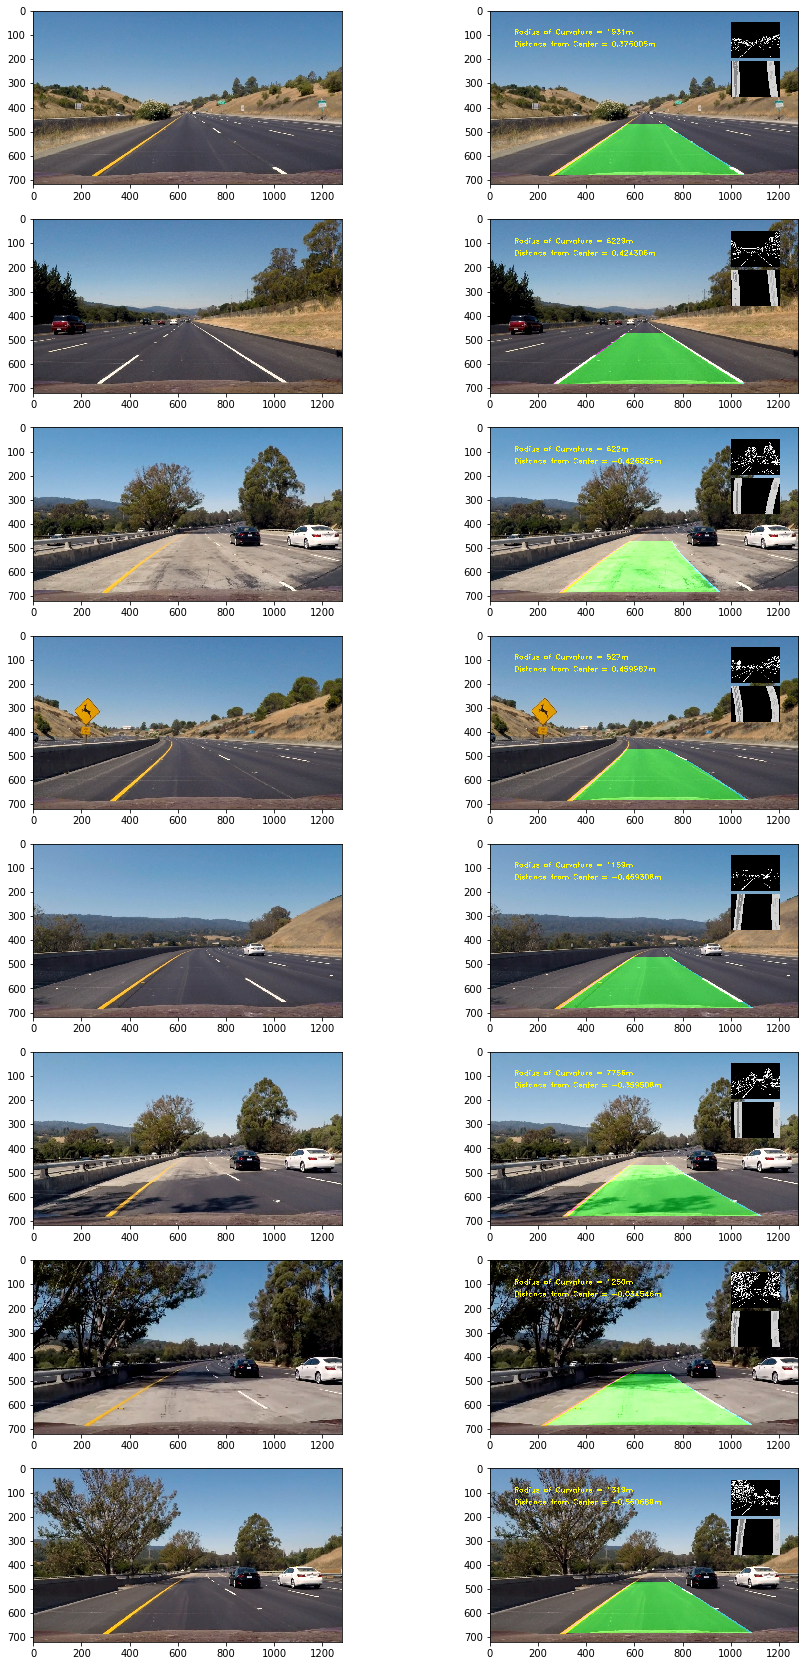

In [16]:
# Testing on test images
f, axes= plt.subplots(8,2,figsize=(15,30))

path_dir = os.getcwd()+"\\test_images\\"
images = glob.glob(path_dir+'/*.jpg') # Reading Images from test_images folder

for index, image in enumerate(images):
    img_input = cv2.imread(image)
    original_img = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    axes[index,0].imshow(original_img)
    result_img = pipeline(original_img)
    #cv2.imwrite('output_images/test_img'+str(index)+'.jpg', cv2.cvtColor(result_img,cv2.COLOR_BGR2RGB))
    axes[index,1].imshow(result_img)

### Running Image Pipeline on sample video

In [17]:
# Running pipeline() on project_video.mp4
import moviepy
from moviepy.editor import VideoFileClip

path_dir = os.getcwd()+"\\output_videos\\"

input_projVideo = VideoFileClip('project_video.mp4')
video_projVideo = path_dir+'project_video_output.mp4'
processed_video = input_projVideo.fl_image(pipeline)
%time processed_video.write_videofile(video_projVideo, audio=False)

[MoviePy] >>>> Building video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\project_video_output.mp4
[MoviePy] Writing video C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:51<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Jandal\workspace_P\UNDSC\CarND-Advanced-Lane-Lines\output_videos\project_video_output.mp4 

Wall time: 6min 54s


In [ ]:
# Running pipeline() on challenge_video.mp4
input_challengeVideo = VideoFileClip('challenge_video.mp4')
video_challengeVideo = path_dir+'challenge_video_output.mp4'
processed_video = input_challengeVideo.fl_image(pipeline)
%time processed_video.write_videofile(video_challengeVideo, audio=False)

In [ ]:
# Running pipeline() on harder_challenge_video.mp4
input_hardChallenge = VideoFileClip('harder_challenge_video.mp4')
video_hardChallenge = path_dir+'harder_challenge_video_output.mp4'
processed_video = input_hardChallenge.fl_image(pipeline)
%time processed_video.write_videofile(video_hardChallenge, audio=False)